In [82]:
# !pip install ta
# !pip install quantreo
# !pip install feature-engine
# !pip install catboost

#### LOAD LIBRARIES

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import ta
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import quantreo.features_engineering as fe
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score

#### LOAD DATA

In [7]:
spy_data = pd.read_pickle('net_gex.pkl')
vix_data = pd.read_pickle('VIX_May_2025.pkl')
spy_win_loss_outcome = pd.read_csv('SPY_good_bad_patterns.csv')

posve_net_gex_max_strike_1 = pd.read_pickle('+ve Net Gex Max Strike 1.pkl')
posve_net_gex_max_strike_2 = pd.read_pickle('+ve Net Gex Max Strike 2.pkl')
posve_net_gex_max_strike_3 = pd.read_pickle('+ve Net Gex Max Strike 3.pkl')
negve_net_gex_max_strike_1 = pd.read_pickle('-ve Net Gex Max Strike 1.pkl')
negve_net_gex_max_strike_2 = pd.read_pickle('-ve Net Gex Max Strike 2.pkl')
negve_net_gex_max_strike_3 = pd.read_pickle('-ve Net Gex Max Strike 3.pkl')
call_block_strike = pd.read_pickle('Call Block Strike.pkl')
call_ol_percent = pd.read_pickle('Call OI%.pkl')
call_volume_percent = pd.read_pickle('Call Volume %.pkl')
gamma_flip_strike = pd.read_pickle('Gamma Flip Strike.pkl')
max_abs_gex_strike = pd.read_pickle('Max Abs GEX Strike.pkl')
max_call_ol_strike = pd.read_pickle('Max Call OI Strike.pkl')
max_call_volume_strike = pd.read_pickle('Max Call Volume Strike.pkl')
max_call_wall_strike = pd.read_pickle('Max Call Wall Strike.pkl')
max_negative_net_gex_strike = pd.read_pickle('Max Negative Net GEX Strike.pkl')
max_pain_strike = pd.read_pickle('Max Pain Strike.pkl')
max_positive_net_gex_strike = pd.read_pickle('Max Positive Net GEX Strike.pkl')
max_put_ol_strike = pd.read_pickle('Max Put OI Strike.pkl')
max_put_volume_strike = pd.read_pickle('Max Put Volume Strike.pkl')
min_put_wall_strike = pd.read_pickle('Min Put Wall Strike.pkl')
net_notional_delta = pd.read_pickle('Net Notional Delta.pkl')
net_flow = pd.read_pickle('NetFlow.pkl')
pcr_volume = pd.read_pickle('PCR Volume.pkl')
pcr = pd.read_pickle('PCR.pkl')
projected_max_pain_strike = pd.read_pickle('Projected Max Pain Strike.pkl')
put_block_strike = pd.read_pickle('Put Block Strike.pkl')
put_ol_percent = pd.read_pickle('Put OI%.pkl')
put_volume_percent = pd.read_pickle('Put Volume % .pkl')

total_call_ol = pd.read_pickle('Total Call OI.pkl')
total_call_volume = pd.read_pickle('Total Call Volume.pkl')
total_ol = pd.read_pickle('Total OI.pkl')
total_put_volume = pd.read_pickle('Total Put Volume.pkl')
total_volume = pd.read_pickle('Total Volume.pkl')
va_high_strike = pd.read_pickle('VA High Strike.pkl')
va_low_strike = pd.read_pickle('VA Low Strike .pkl')
vr_high_strike = pd.read_pickle('VR High Strike.pkl')
vr_low_strike = pd.read_pickle('VR Low Strike.pkl')

In [8]:
#strike datasets
strike_datsets = {
    'posve_net_gex_max_strike_1': posve_net_gex_max_strike_1,
    'posve_net_gex_max_strike_2': posve_net_gex_max_strike_2,
    'posve_net_gex_max_strike_3': posve_net_gex_max_strike_3,
    'negve_net_gex_max_strike_1': negve_net_gex_max_strike_1,
    'negve_net_gex_max_strike_2': negve_net_gex_max_strike_2,
    'negve_net_gex_max_strike_3': negve_net_gex_max_strike_3,
    'call_block_strike': call_block_strike,
    'gamma_flip_strike': gamma_flip_strike,
    'max_abs_gex_strike': max_abs_gex_strike,
    'max_call_ol_strike': max_call_ol_strike,
    'max_call_volume_strike': max_call_volume_strike,
    'max_call_wall_strike': max_call_wall_strike,
    'max_negative_net_gex_strike': max_negative_net_gex_strike,
    'max_pain_strike': max_pain_strike,
    'max_positive_net_gex_strike': max_positive_net_gex_strike,
    'max_put_ol_strike': max_put_ol_strike,
    'max_put_volume_strike': max_put_volume_strike,
    'min_put_wall_strike': min_put_wall_strike,
    'projected_max_pain_strike': projected_max_pain_strike,
    'put_block_strike': put_block_strike,
    'va_high_strike': va_high_strike,
    'va_low_strike': va_low_strike,
    'vr_high_strike': vr_high_strike,
    'vr_low_strike': vr_low_strike
}

In [9]:
#volume datasets
volume_datasets = {
    'net_notional_delta': net_notional_delta,
    'net_flow': net_flow,
    'pcr_volume': pcr_volume,
    'pcr': pcr,
    'total_call_ol': total_call_ol,
    'total_call_volume': total_call_volume,
    'total_ol': total_ol,
    'total_put_volume': total_put_volume,
    'total_volume': total_volume,
}

In [10]:
#percent datasets
percent_datasets = {
    'put_volume_percent': put_volume_percent,
    'put_ol_percent': put_ol_percent,
    'call_volume_percent': call_volume_percent,
    'call_ol_percent': call_ol_percent,
}


#### DATA EXPLORATION & CLEANING

In [11]:
call_ol_percent.head()

,timestamp,open,high,low,close
0,2023-04-03 09:36:00-04:00,29.0,29.0,29.0,29.0
1,2023-04-03 09:37:00-04:00,29.0,29.0,29.0,29.0
2,2023-04-03 09:38:00-04:00,29.0,29.0,29.0,29.0
3,2023-04-03 09:39:00-04:00,29.0,29.0,29.0,29.0
4,2023-04-03 09:40:00-04:00,29.0,29.0,29.0,29.0


In [12]:
negve_net_gex_max_strike_2.head()

,timestamp,open,high,low,close
0,2023-04-03 09:36:00-04:00,409.0,409.0,409.0,409.0
1,2023-04-03 09:37:00-04:00,409.0,409.0,409.0,409.0
2,2023-04-03 09:38:00-04:00,409.0,409.0,409.0,409.0
3,2023-04-03 09:39:00-04:00,409.0,409.0,409.0,409.0
4,2023-04-03 09:40:00-04:00,405.0,405.0,405.0,405.0


### VIX

In [13]:
vix_data.head()

,timestamp,open,high,low,close,volume
0,2023-04-03 09:31:00-04:00,19.58,19.58,19.53,19.54,0.0
1,2023-04-03 09:32:00-04:00,19.52,19.52,19.52,19.52,0.0
2,2023-04-03 09:33:00-04:00,19.51,19.51,19.49,19.49,0.0
3,2023-04-03 09:34:00-04:00,19.47,19.47,19.46,19.46,0.0
4,2023-04-03 09:35:00-04:00,19.47,19.47,19.45,19.45,0.0


In [14]:
vix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190711 entries, 0 to 190710
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype                           
---  ------     --------------   -----                           
 0   timestamp  190711 non-null  datetime64[ns, America/New_York]
 1   open       190711 non-null  float64                         
 2   high       190711 non-null  float64                         
 3   low        190711 non-null  float64                         
 4   close      190711 non-null  float64                         
 5   volume     190711 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5)
memory usage: 8.7 MB


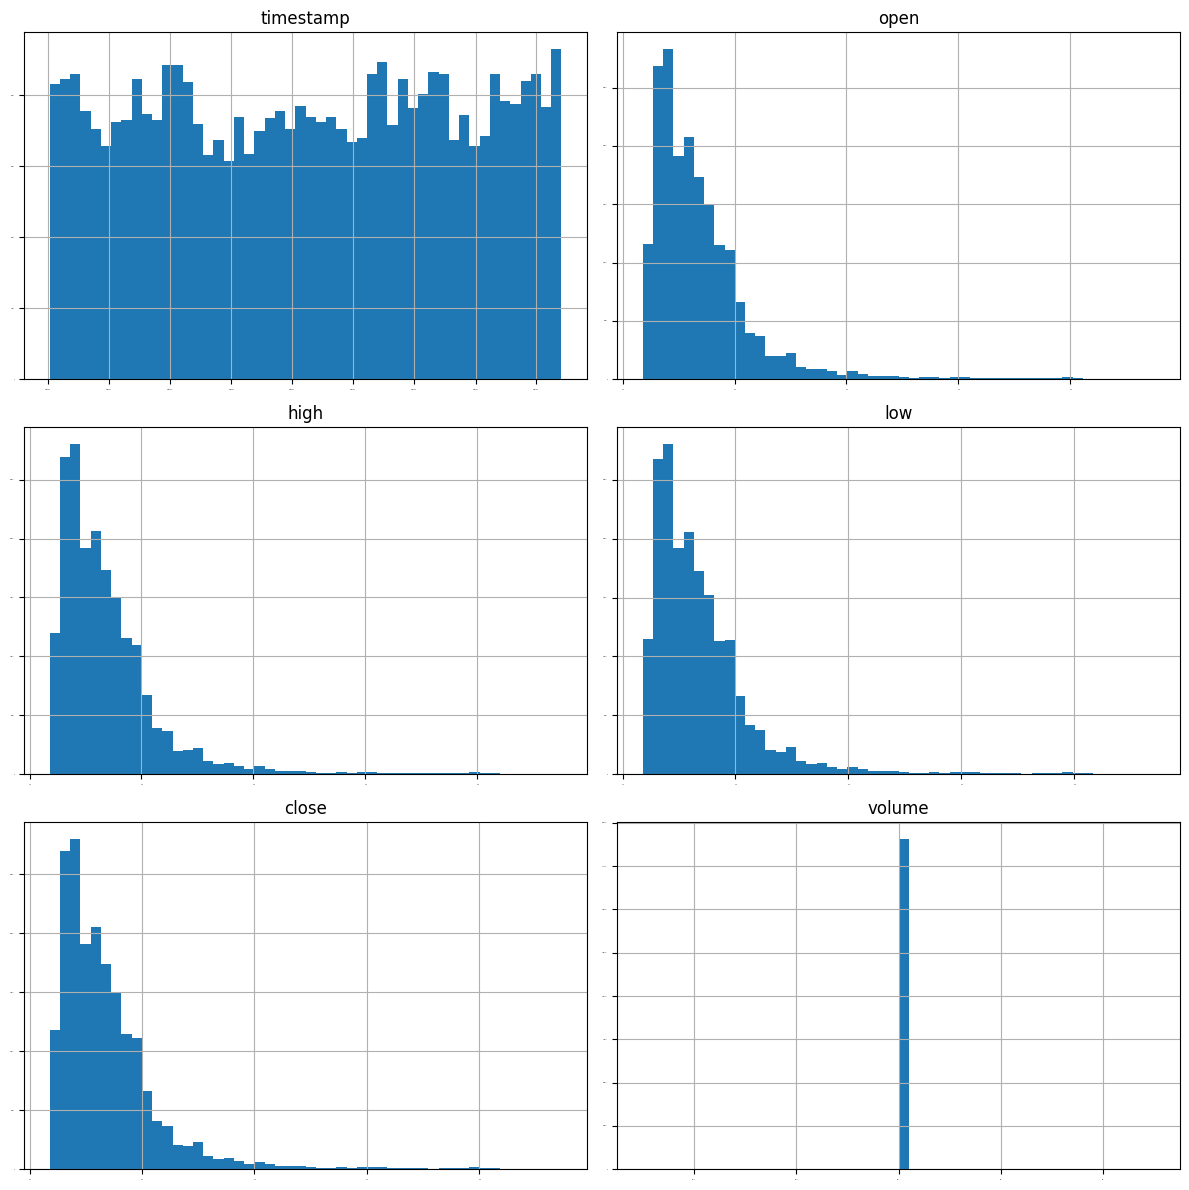

In [15]:
vix_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

The vix data is evidently skewed as expected. Taking the log of the close price can improve its predictive power in a linear model.

SPY_OUTCOME

In [16]:
spy_win_loss_outcome.head()

,Start Date,Open Price (11 AM),Status,Lowest Candle Time,Lowest Price,First Higher Candle Time,First Higher Price,Highest Candle Time,Highest Price,Last Candle Time,...,Weekday,11am Close,target_date,outcome,Partial W/L,pattern,pattern_5,vix_regime,observation,observation_5
0,2020-01-02,323.94,Good,2020-01-03 10:00:00,319.69,2020-01-10 10:00:00,327.5000,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,3,323.63,2020-01-10 16:00:00,W,PL,NaN,NaN,Low,NaN,NaN
1,2020-01-03,320.15,Good,2020-01-03 11:00:00,320.06,2020-01-07 10:00:00,323.9100,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,4,320.55,2020-01-10 16:00:00,W,PW,NaN,NaN,Low,NaN,NaN
2,2020-01-06,320.71,Good,2020-01-06 13:00:00,320.06,2020-01-07 11:00:00,323.9300,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,0,320.72,2020-01-10 16:00:00,W,PW,NaN,NaN,Low,NaN,NaN
3,2020-01-07,323.76,Good,2020-01-08 13:00:00,320.89,2020-01-10 10:00:00,327.5000,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,1,323.41,2020-01-10 16:00:00,W,PL,WWW,NaN,Low,WWW_Low,NaN
4,2020-01-08,323.26,Good,2020-01-08 13:00:00,320.89,2020-01-09 15:00:00,326.5598,2020-01-10 11:00:00,327.74,2020-01-10 16:00:00,...,2,323.12,2020-01-10 16:00:00,W,PL,WWW,NaN,Low,WWW_Low,NaN


In [17]:
spy_win_loss_outcome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Start Date                1343 non-null   object 
 1   Open Price (11 AM)        1343 non-null   float64
 2   Status                    1343 non-null   object 
 3   Lowest Candle Time        1343 non-null   object 
 4   Lowest Price              1343 non-null   float64
 5   First Higher Candle Time  798 non-null    object 
 6   First Higher Price        798 non-null    float64
 7   Highest Candle Time       1343 non-null   object 
 8   Highest Price             1343 non-null   float64
 9   Last Candle Time          1343 non-null   object 
 10  Last Price                1343 non-null   float64
 11  Around Earning            1343 non-null   int64  
 12  VIX                       1337 non-null   float64
 13  Weekday                   1343 non-null   int64  
 14  11am Clo

SPY

In [18]:
spy_data.head()

,Spot_open,Spot_high,Spot_low,Spot_close,Spot_volume,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex,PCT_EPS_1mo_open,PCT_EPS_1mo_high,PCT_EPS_1mo_low,PCT_EPS_1mo_close
timestamp,,,,,,,,,,,,,,,,,,,
2023-04-03 09:36:00-04:00,409.5500,409.78,409.4805,409.7405,382158.0,9.334125e+08,9.334125e+08,9.334125e+08,9.334125e+08,0.0,-6.169928e+05,-6.169928e+05,-6.169928e+05,-6.169928e+05,0.0,0.381196,0.381196,0.381196,0.381196
2023-04-03 09:37:00-04:00,409.7500,409.79,409.6300,409.7700,352560.0,9.338911e+08,9.338911e+08,9.338911e+08,9.338911e+08,0.0,-6.173091e+05,-6.173091e+05,-6.173091e+05,-6.173091e+05,0.0,0.378447,0.378447,0.378447,0.378447
2023-04-03 09:38:00-04:00,409.7900,409.87,409.7300,409.8100,184768.0,9.340051e+08,9.340051e+08,9.340051e+08,9.340051e+08,0.0,-6.173845e+05,-6.173845e+05,-6.173845e+05,-6.173845e+05,0.0,0.373660,0.373660,0.373660,0.373660
2023-04-03 09:39:00-04:00,409.8101,409.86,409.7318,409.8400,212706.0,9.340507e+08,9.340507e+08,9.340507e+08,9.340507e+08,0.0,-6.174146e+05,-6.174146e+05,-6.174146e+05,-6.174146e+05,0.0,0.371429,0.371429,0.371429,0.371429
2023-04-03 09:40:00-04:00,409.8600,409.91,409.7564,409.7899,227595.0,9.383326e+08,9.383326e+08,9.383326e+08,9.383326e+08,0.0,7.578217e+07,7.578217e+07,7.578217e+07,7.578217e+07,0.0,0.375319,0.375319,0.375319,0.375319


In [19]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201124 entries, 2023-04-03 09:36:00-04:00 to 2025-05-09 15:58:00-04:00
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Spot_open          201124 non-null  float64
 1   Spot_high          201124 non-null  float64
 2   Spot_low           201124 non-null  float64
 3   Spot_close         201124 non-null  float64
 4   Spot_volume        201124 non-null  float64
 5   open_abs_gex       201124 non-null  float64
 6   high_abs_gex       201124 non-null  float64
 7   low_abs_gex        201124 non-null  float64
 8   close_abs_gex      201124 non-null  float64
 9   volume_abs_gex     201124 non-null  float64
 10  open_net_gex       201124 non-null  float64
 11  high_net_gex       201124 non-null  float64
 12  low_net_gex        201124 non-null  float64
 13  close_net_gex      201124 non-null  float64
 14  volume_net_gex     201124 non-null  float64
 15  PCT_E

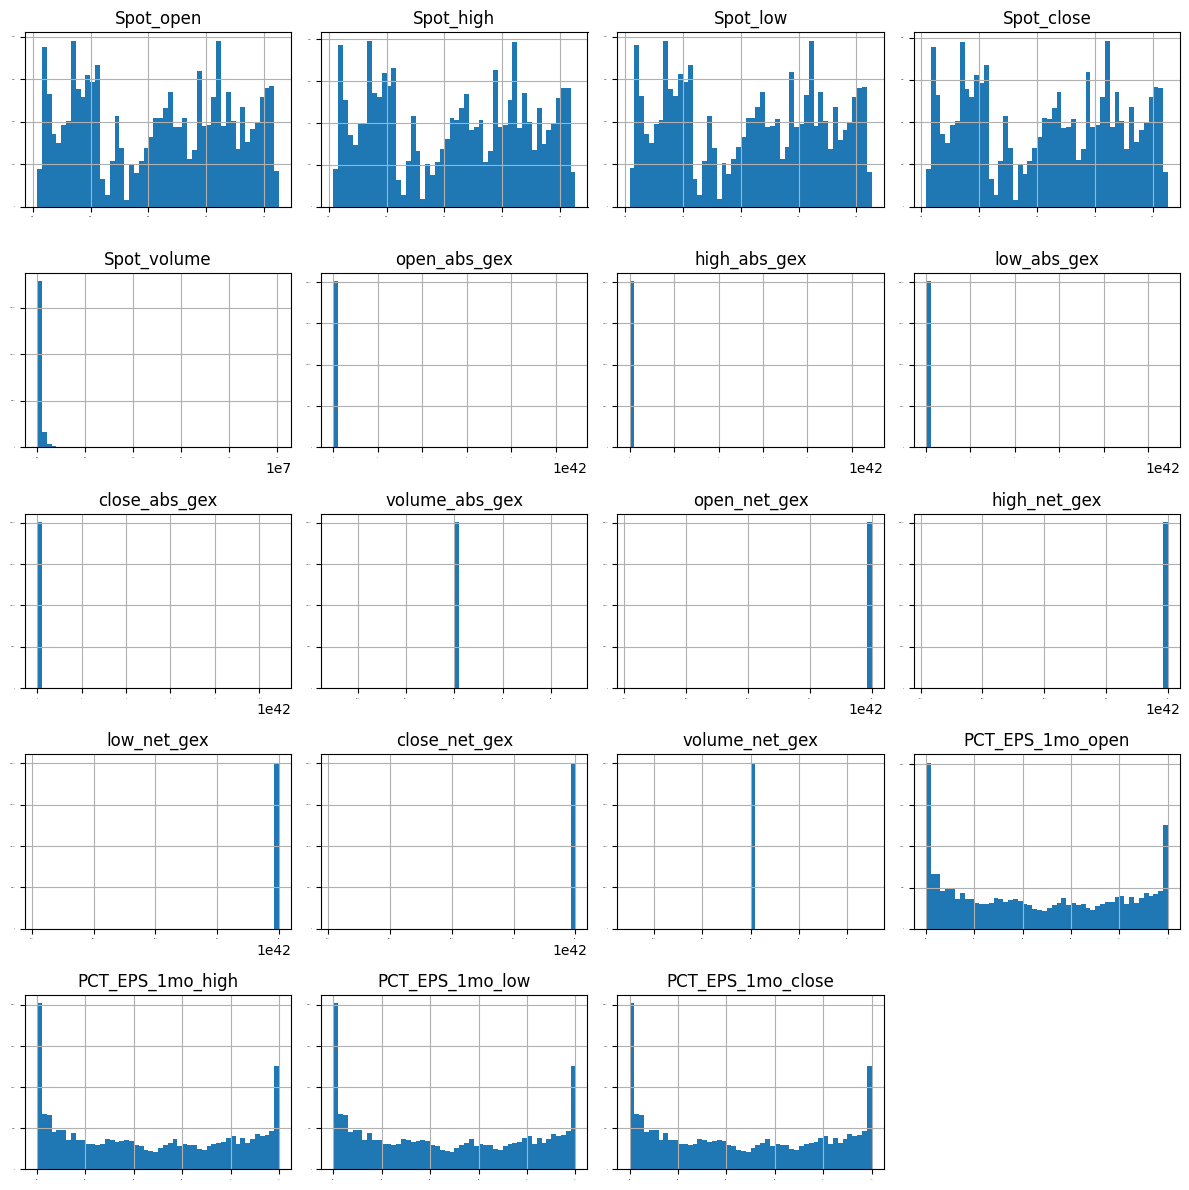

In [20]:
spy_data.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.tight_layout()
plt.show()

#### SUMMARY STATISTICS

In [21]:
spy_data.describe()

,Spot_open,Spot_high,Spot_low,Spot_close,Spot_volume,open_abs_gex,high_abs_gex,low_abs_gex,close_abs_gex,volume_abs_gex,open_net_gex,high_net_gex,low_net_gex,close_net_gex,volume_net_gex,PCT_EPS_1mo_open,PCT_EPS_1mo_high,PCT_EPS_1mo_low,PCT_EPS_1mo_close
count,201124.000000,201124.000000,201124.000000,201124.000000,2.011240e+05,2.011240e+05,2.011240e+05,2.011240e+05,2.011240e+05,201124.0,2.011240e+05,2.011240e+05,2.011240e+05,2.011240e+05,201124.0,201124.000000,201124.000000,201124.000000,201124.000000
mean,508.706031,508.826137,508.585630,508.706264,1.413679e+05,1.081389e+38,1.081389e+38,1.081389e+38,1.081389e+38,0.0,-3.887679e+37,-3.887679e+37,-3.887679e+37,-3.887679e+37,0.0,0.463067,0.463067,0.463067,0.463067
std,62.857117,62.874179,62.840862,62.856849,2.005403e+05,2.424827e+40,2.424827e+40,2.424827e+40,2.424827e+40,0.0,8.717448e+39,8.717448e+39,8.717448e+39,8.717448e+39,0.0,0.338566,0.338566,0.338566,0.338566
min,403.790000,403.970000,403.740000,403.795000,4.982000e+03,-7.000000e-06,-7.000000e-06,-7.000000e-06,-7.000000e-06,0.0,-1.957090e+42,-1.957090e+42,-1.957090e+42,-1.957090e+42,0.0,0.000122,0.000122,0.000122,0.000122
25%,447.435000,447.510000,447.353750,447.433900,5.681400e+04,7.462253e+08,7.462253e+08,7.462253e+08,7.462253e+08,0.0,-2.218065e+08,-2.218065e+08,-2.218065e+08,-2.218065e+08,0.0,0.134921,0.134921,0.134921,0.134921
50%,514.840000,514.970000,514.700000,514.837450,9.358800e+04,9.844438e+08,9.844438e+08,9.844438e+08,9.844438e+08,0.0,5.359402e+07,5.359402e+07,5.359402e+07,5.359402e+07,0.0,0.430769,0.430769,0.430769,0.430769
75%,562.430000,562.560000,562.280000,562.430000,1.592180e+05,1.294341e+09,1.294341e+09,1.294341e+09,1.294341e+09,0.0,3.354312e+08,3.354312e+08,3.354312e+08,3.354312e+08,0.0,0.785226,0.785226,0.785226,0.785226
max,613.145000,613.230000,613.100000,613.173500,1.260397e+07,5.443800e+42,5.443800e+42,5.443800e+42,5.443800e+42,0.0,2.705825e+09,2.705825e+09,2.705825e+09,2.705825e+09,0.0,1.000000,1.000000,1.000000,1.000000


In [22]:
vix_data.describe()

,open,high,low,close,volume
count,190711.000000,190711.000000,190711.000000,190711.000000,190711.0
mean,16.966819,16.983168,16.951123,16.967270,0.0
std,4.806470,4.823645,4.791359,4.808279,0.0
min,11.780000,11.800000,11.780000,11.790000,0.0
25%,13.860000,13.860000,13.850000,13.860000,0.0
50%,15.870000,15.880000,15.850000,15.870000,0.0
75%,18.520000,18.540000,18.500000,18.520000,0.0
max,57.520000,57.520000,57.090000,57.300000,0.0


All dataset have zero filled volume values, so they all have to be dropped.

#### Segment strike data

In [23]:
max_put_volume_strike

,timestamp,open,high,low,close
0,2023-04-03 09:36:00-04:00,408.0,408.0,408.0,408.0
1,2023-04-03 09:37:00-04:00,408.0,408.0,408.0,408.0
2,2023-04-03 09:38:00-04:00,408.0,408.0,408.0,408.0
3,2023-04-03 09:39:00-04:00,408.0,408.0,408.0,408.0
4,2023-04-03 09:40:00-04:00,408.0,408.0,408.0,408.0
...,...,...,...,...,...
201119,2025-05-09 15:54:00-04:00,564.0,564.0,564.0,564.0
201120,2025-05-09 15:55:00-04:00,564.0,564.0,564.0,564.0
201121,2025-05-09 15:56:00-04:00,564.0,564.0,564.0,564.0
201122,2025-05-09 15:57:00-04:00,564.0,564.0,564.0,564.0


#### DEFINE FUNCTIONS

In [25]:
def reduce_to_close_column(data_df):
    '''
    This takes as input datasets in the same category, selects just the close variable while eliminating the rest
    parameters:
    data_df: dict

    returns:
    merged_df: dataframe

    '''
    renamed_dfs = []

    for name, df in data_df.items():
        temp = df[['timestamp', 'close']].copy()
        temp.set_index('timestamp', inplace=True)
        temp.rename(columns={'close': f'{name}'}, inplace=True)
        renamed_dfs.append(temp)

    # Join all DataFrames on index (timestamp)
    from functools import reduce
    merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), renamed_dfs)

    return merged_df

In [26]:
def data_cleaning(df):
    '''
    This cleans the dataset by eliminating zero filled columns and unnecessary negative absolute gamma exposure values

    parameters:
    df: dataframe
    asset_name: str

    returns:
    df_copy: dataframe

    '''
    df_copy = df.copy()

    #remove rows with negative gamma exposure if the column exist in the dataset
    if 'close_abs_gex' in df_copy.columns:
        df_copy = df_copy.drop(df_copy[df_copy['close_abs_gex'] < 0].index)

    # Drop volume_abs_gex and volume_net_gex, if they exist (because they contain zero values)
    for col in ['volume_abs_gex', 'volume_net_gex', 'volume']:
        if col in df_copy.columns:
            df_copy = df_copy.drop(columns=[col])

    # Rename Spot columns to standard names, only if they exist
    rename_map = {
        'Spot_open': 'open',
        'Spot_high': 'high',
        'Spot_close': 'close',
        'Spot_low': 'low'}

    existing_rename_map = {k: v for k, v in rename_map.items() if k in df_copy.columns}
    df_copy = df_copy.rename(columns=existing_rename_map)

    return df_copy


In [27]:
def fft_imag_coeff_3(x):
    """
    Calculate the imaginary part of the 3rd FFT coefficient.

    Parameters:
    x : array-like (e.g., list or 1D np.array)
        The time series values (e.g., low prices from 9am to 11am)

    Returns:
    float
        Imaginary part of the 3rd FFT coefficient
    """
    x = np.asarray(x)
    fft_coeffs = np.fft.fft(x)  # Compute FFT
    if len(fft_coeffs) >= 4:
        return np.imag(fft_coeffs[3])  # 3rd coefficient (0-based index = 3)
    else:
        return np.nan  # Not enough data to compute coefficient 3


In [28]:
def apply_fft_image_coeff_3(df, name):
    '''
    This resamples the minute-level price data into daily slices up to 11am,
    and applies FFT to 'open', 'high', 'low', 'close' to extract the
    imaginary part of the 3rd frequency coefficient.

    Parameters:
    df: DataFrame with 'timestamp', 'open', 'high', 'low', 'close'
    name: Asset name (used as prefix for output column names)

    Returns:
    fft_feature_df: Daily DataFrame with FFT features for all 4 price columns
    '''
    df_copy = df.copy()

    # Ensure timestamp column exists and is datetime
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    # Extract date and filter until 11am
    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    # List of price columns to process
    price_cols = ['open', 'high', 'low', 'close']

    # Compute FFT features for each column
    features = {}
    for col in price_cols:
        features[col] = df_copy.groupby('date')[col].apply(fft_imag_coeff_3)

    # Combine all into a single DataFrame
    fft_feature_df = pd.DataFrame(features).reset_index()

    # Rename columns to include asset name and tsfresh-style format
    fft_feature_df.rename(columns={col: f"{name}_{col}__fft_imag_coeff_3" for col in price_cols}, inplace=True)

    return fft_feature_df

In [29]:
def previous_day_data(df, asset):
    '''
    The function generates previous close price and close_net_gex values for the previous day until the past 5 days.

    parameters:
    df: dataframe
    asset: str, asset name

    returns:
    prev_day_agg: dataframe
    '''
    # From raw (untrimmed) data
    raw_df = df.copy()
    # Check if datetime is a column or index
    if 'timestamp' in raw_df.columns:
        raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])
    else:
        raw_df['timestamp'] = pd.to_datetime(raw_df.index)

    prev_day_col = {
        'close': 'last',
        'close_net_gex' : 'last'}


    #Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in prev_day_col.items() if k in raw_df.columns}
    grouped = raw_df.groupby(raw_df['timestamp'].dt.date).agg(selected_agg).sort_index()

    prev_day_agg   = grouped.pct_change(1)
    prev_2day_agg  = grouped.pct_change(2)
    prev_3day_agg  = grouped.pct_change(3)
    prev_4day_agg  = grouped.pct_change(4)
    prev_5day_agg  = grouped.pct_change(5)

    prev_day_agg.columns = [f'prev_day_{col}_{asset}' for col in prev_day_agg.columns]
    prev_2day_agg.columns = [f'prev_2day_{col}_{asset}' for col in prev_2day_agg.columns]
    prev_3day_agg.columns = [f'prev_3day_{col}_{asset}' for col in prev_3day_agg.columns]
    prev_4day_agg.columns = [f'prev_4day_{col}_{asset}' for col in prev_4day_agg.columns]
    prev_5day_agg.columns = [f'prev_5day_{col}_{asset}' for col in prev_5day_agg.columns]
    prev_day_agg.index.name = 'timestamp'
    prev_2day_agg.index.name = 'timestamp'
    prev_3day_agg.index.name = 'timestamp'
    prev_4day_agg.index.name = 'timestamp'
    prev_5day_agg.index.name = 'timestamp'
    prev_day_agg = pd.concat([prev_day_agg, prev_2day_agg, prev_3day_agg, prev_4day_agg, prev_5day_agg], axis=1)

    return prev_day_agg

In [30]:
def resample_minute_data(df, name):
    '''
    This resamples the minute data into daily data, but until 11 am that day.

    parameters:
    df: dataframe
    name: asset name str

    returns:
    agg_df: dataframe

    '''
    df_copy = df.copy()

    # Check if datetime is a column or index
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy['time'] = df_copy['timestamp'].dt.time

    #select data upuntil 11 am that day
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    agg_map = {
        'open': 'first',
        'close': 'last',
        'high': 'max',
        'low': 'min',
        'PCT_EPS_1mo_open': 'first',
        'PCT_EPS_1mo_close': 'last',
        'PCT_EPS_1mo_high': 'max',
        'PCT_EPS_1mo_low': 'min',
        'open_abs_gex': 'first',
        'high_abs_gex': 'max',
        'low_abs_gex' : 'min',
        'close_abs_gex' : 'last',
        'open_net_gex': 'first',
        'high_net_gex' : 'max',
        'low_net_gex' : 'min',
       'close_net_gex' : 'last'}


    # Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in agg_map.items() if k in df_copy.columns}
    agg_df = df_copy.groupby('date').agg(selected_agg).reset_index()

    # Rename columns with prefix (except 'date')
    agg_df.rename(columns=lambda col: col if col == 'date' else f'11am_{name}_{col}', inplace=True)

    return agg_df


In [31]:
def resample_minute_volume_data(df):
    '''
    This resamples the minute data into daily data, but until 11 am that day.

    parameters:
    df: dataframe
    name: asset name str

    returns:
    agg_df: dataframe

    '''
    df_copy = df.copy()

    # Check if datetime is a column or index
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy['time'] = df_copy['timestamp'].dt.time

    #select data upuntil 11 am that day
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    agg_map = {
    'net_notional_delta': 'last',
    'net_flow': 'sum',
    'pcr_volume': 'last',
    'pcr': 'last',
    'total_call_ol': 'last',
    'total_call_volume': 'sum',
    'total_ol': 'last',
    'total_put_volume': 'sum',
    'total_volume': 'sum',
}

    # Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in agg_map.items() if k in df_copy.columns}
    agg_df = df_copy.groupby('date').agg(selected_agg).reset_index()

    # Rename columns with prefix (except 'date')
    agg_df.rename(columns=lambda col: col if col == 'date' else f'{col}', inplace=True)

    return agg_df

In [32]:
def resample_minute_strike_data(df):
    '''
    This resamples the minute data into daily data, but until 11 am that day.

    parameters:
    df: dataframe
    name: asset name str

    returns:
    agg_df: dataframe

    '''
    df_copy = df.copy()

    # Check if datetime is a column or index
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy['time'] = df_copy['timestamp'].dt.time

    #select data upuntil 11 am that day
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    agg_map = {

    'posve_net_gex_max_strike_1': 'max',
    'posve_net_gex_max_strike_2': 'max',
    'posve_net_gex_max_strike_3': 'max',
    'negve_net_gex_max_strike_1': 'min',
    'negve_net_gex_max_strike_2': 'min',
    'negve_net_gex_max_strike_3': 'min',
    'call_block_strike': 'last',
    'gamma_flip_strike': 'last',
    'max_abs_gex_strike': 'last',
    'max_call_ol_strike': 'max',
    'max_call_volume_strike': 'max',
    'max_call_wall_strike': 'max',
    'max_negative_net_gex_strike': 'min',
    'max_pain_strike': 'last',
    'max_positive_net_gex_strike': 'max',
    'max_put_ol_strike': 'max',
    'max_put_volume_strike': 'max',
    'min_put_wall_strike': 'min',
    'projected_max_pain_strike': 'last',
    'put_block_strike': 'last',
    'va_high_strike': 'max',
    'va_low_strike': 'min',
    'vr_high_strike': 'max',
    'vr_low_strike': 'min'
}


    # Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in agg_map.items() if k in df_copy.columns}
    agg_df = df_copy.groupby('date').agg(selected_agg).reset_index()

    # Rename columns with prefix (except 'date')
    agg_df.rename(columns=lambda col: col if col == 'date' else f'{col}', inplace=True)

    return agg_df

In [33]:
def resample_minute_percent_data(df):
    '''
    This resamples the minute data into daily data, but until 11 am that day.

    parameters:
    df: dataframe
    name: asset name str

    returns:
    agg_df: dataframe

    '''
    df_copy = df.copy()

    # Check if datetime is a column or index
    if 'timestamp' in df_copy.columns:
        df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    else:
        df_copy['timestamp'] = pd.to_datetime(df_copy.index)

    df_copy['date'] = df_copy['timestamp'].dt.date
    df_copy['time'] = df_copy['timestamp'].dt.time

    #select data upuntil 11 am that day
    df_copy = df_copy[df_copy['timestamp'].dt.time <= pd.to_datetime('11:00:00').time()]

    agg_map = {
    'put_volume_percent': 'last',
    'put_ol_percent': 'last',
    'call_volume_percent': 'last',
    'call_ol_percent': 'last',
}

    # Keep only keys that exist in the DataFrame
    selected_agg = {k: v for k, v in agg_map.items() if k in df_copy.columns}
    agg_df = df_copy.groupby('date').agg(selected_agg).reset_index()

    # Rename columns with prefix (except 'date')
    agg_df.rename(columns=lambda col: col if col == 'date' else f'{col}', inplace=True)

    return agg_df

In [34]:
def target_engineering(df):
    '''
    This function performs engineering on the target variable to convert them to integers.

    parameters:
    df: Dataframe

    Returns:
    df_copy: The original dataset including engineered features
    '''

    labels = {'W': 1, 'L':0}
    df_copy = df.copy()
    df_copy['outcome'] = df_copy['outcome'].map(labels)
    return df_copy


In [112]:
def rolling_slope(series, window):
    '''
    This function calculates the rolling slope of the gamma exposure values
    parameters:
    series: series
    window: int

    Returns:
    slopes: list
    '''
    slopes = [np.nan] * window
    X = np.arange(window).reshape(-1,1)
    for i in range(window, len(series)):
        y = series[i-window:i]
        model = LinearRegression().fit(X, y)
        slopes.append(model.coef_[0])
    return np.array(slopes)

In [469]:
def feature_engineering1(df, asset):
    '''
    This function performs engineering to generate new predictive features.

    parameters:
    df: Dataframe
    asset: the name of the asset

    Returns:
    df_copy: The original dataset including engineered features

    '''
    df_copy = df.copy()
    df_copy[f'{asset}_rolling_mean_past_close_3'] = df_copy[[f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                  f'prev_3day_close_{asset}']].mean(axis=1)
    df_copy[f'{asset}_rolling_std_past_close_3'] = df_copy[[f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                  f'prev_3day_close_{asset}']].std(axis=1)

    if f'prev_day_close_net_gex_{asset}' in df_copy.columns:
         df_copy['net_gamma_slope'] = rolling_slope(df_copy['11am_SPY_close_net_gex'].values, window=5)
         df_copy[f'{asset}_sharpe_3'] = df_copy[f'{asset}_rolling_mean_past_close_3'] / (df_copy[f'{asset}_rolling_std_past_close_3'] + 1e-6)
         df_copy[f'{asset}_kama_(moving_average)'] = fe.trend.kama(df_copy, col=f'11am_{asset}_close',l1 = 3, l3= 5)

    #DROP COLUMNS
    df_copy.drop(columns= [f'11am_{asset}_close',f'11am_{asset}_open', f'prev_day_close_{asset}', f'prev_2day_close_{asset}',
                                 f'prev_3day_close_{asset}', f'prev_4day_close_{asset}', f'prev_5day_close_{asset}'], inplace=True)

    if f'11am_{asset}_PCT_EPS_1mo_open' in df_copy.columns:
        df_copy.drop(columns= [f'11am_SPY_PCT_EPS_1mo_open', f'11am_SPY_PCT_EPS_1mo_high', f'11am_SPY_PCT_EPS_1mo_low',
                               f'prev_day_close_net_gex_{asset}', f'prev_2day_close_net_gex_{asset}',f'{asset}_rolling_std_past_close_3',
                                    f'prev_3day_close_net_gex_{asset}', f'prev_4day_close_net_gex_{asset}',f'prev_5day_close_net_gex_{asset}',
                               '11am_SPY_open_abs_gex','11am_SPY_low_abs_gex','11am_SPY_high_abs_gex',
                               '11am_SPY_close_abs_gex','11am_SPY_open_net_gex','11am_SPY_low_net_gex','11am_SPY_high_net_gex','11am_SPY_close_net_gex'
                               ], inplace=True)
    else:
        df_copy.drop(columns= [f'11am_{asset}_low',f'11am_{asset}_high', f'{asset}_rolling_mean_past_close_3', f'{asset}_rolling_std_past_close_3'],inplace=True)



    df_copy.dropna(inplace=True)


    return df_copy

In [470]:
def feature_engineering2(df):
    '''
    This function performs engineering to generate days it takes to expiry, and whether the trade closes this friday or the next.

    parameters:
    df: Dataframe

    Returns:
    df_copy: The original dataset including engineered features
    '''
    df_copy = df.copy()

    df_copy['target_date'] = pd.to_datetime(df_copy['target_date'])
    df_copy['days_to_expiry'] = (df_copy['target_date'] - df_copy.index.to_series()).dt.days
    df_copy['expiry_this_friday'] = df_copy['Weekday'].isin([0, 1, 2]).astype(int)

    df_copy.drop(columns=['target_date'], inplace=True)

    return df_copy

In [471]:
def strike_vol_perc_features(df1_stock, df2_strikes, df2_volume, df2_percent):
    df1 = df1_stock.copy()
    df2 = df2_strikes.copy()
    df3 = df2_volume.copy()
    df4 = df2_percent.copy()

    df = df1.merge(df2, on='date', how='inner')
    df = df.merge(df3, on='date', how='inner')
    df = df.merge(df4, on='date', how='inner')


    df['max_pain_dist'] = df['max_pain_strike'] - df['11am_SPY_close']
    df['gamma_flip_proximity'] = df['gamma_flip_strike'] - df['11am_SPY_close']
    df['call_wall_dist'] = df['max_call_wall_strike'] - df['11am_SPY_close']
    df['put_wall_dist'] = df['min_put_wall_strike'] - df['11am_SPY_close']
    df['max_positive_gex_dist'] = df['max_positive_net_gex_strike'] - df['11am_SPY_close']
    df['max_negative_gex_dist'] = df['max_negative_net_gex_strike'] - df['11am_SPY_close']
    df['max_abs_gex_dist'] = df['max_abs_gex_strike'] - df['11am_SPY_close']
    df['projected_max_pain_diff'] = df['projected_max_pain_strike'] - df['max_pain_strike']
    #Barrier/Cluster Directional Pressure
    df['above_gamma_flip'] = (df['11am_SPY_close'] > df['gamma_flip_strike']).astype(int)
    df['near_call_wall'] = np.where(abs(df['11am_SPY_close'] - df['max_call_wall_strike']) < 5, 1, 0)
    #Strike Gradient/Spread Features
    df['gex_gradient'] = df['posve_net_gex_max_strike_1'] -  df['posve_net_gex_max_strike_3']
    df['put_block_gradient'] = df['put_block_strike'] - df['max_put_volume_strike']
    #Range and Volume Pressure Features
    df['va_range'] = (df['va_high_strike'] - df['va_low_strike'])
    df['vr_range'] = (df['vr_high_strike'] - df['vr_low_strike'])
    df['volume_pressure'] = df['max_call_volume_strike'] - df['max_put_volume_strike']
    df['ol_pressure'] = df['max_call_ol_strike'] - df['max_put_ol_strike']
    #Market Pressure Flags
    df['near_max_pain'] = (abs(df['11am_SPY_close'] - df['max_pain_strike']) < 2 ).astype(int)
    df['is_price_between_call_put_block'] = ((df['11am_SPY_close'] < df['call_block_strike']) & (df['11am_SPY_close'] < df['put_block_strike'])).astype(int)
    #Z-Scores of Strike Distances
    df['zscore_call_wall_dist'] = zscore(df['11am_SPY_close'] - df['max_call_wall_strike'])

    #VOLUME FEATURES
    df['net_notional_delta_zscore'] = zscore(df['net_notional_delta'])
    df['net_flow_zscore'] = zscore(df['net_flow'])
    df['net_flow_change'] = df['net_flow'].diff()
    #Put/Call Sentiment Ratios
    df['pcr_volume_ma5'] = (df['pcr_volume']).rolling(5).mean()
    df['pcr_volume_zscore'] = zscore(df['pcr_volume'])
    df['pcr_diff'] = df['pcr'].diff()
    #Volume Pressure Features
    df['call_domination'] = (df['total_call_volume'] - df['total_put_volume']) / df['total_volume']
    df['call_volume_ratio'] = df['total_call_volume'] / df['total_volume']
    df['put_volume_ratio'] = df['total_put_volume'] / df['total_volume']
    df['call_volume_mom'] = df['total_call_volume'].diff()
    df['put_volume_mom'] = df['total_put_volume'].diff()
    #Normalized and Trend Features
    df['total_volume_z'] = zscore(df['total_volume'])
    df['net_notional_delta_z'] = zscore(df['net_notional_delta'])
    df['call_vol_rolling_std'] = (df['total_call_volume']).rolling(5).std()

    #PERCENT FEATURES
    df['call_volume_dominance'] = (df['call_volume_percent'] - df['put_volume_percent']) / df['put_volume_percent']
    df['put_volume_dominance'] = (df['put_volume_percent'] - df['call_volume_percent'])
    df['call_ol_dominance'] = (df['call_ol_percent'] - df['put_ol_percent'])
    df['put_ol_dominance'] = (df['put_ol_percent'] - df['call_ol_percent'])
    df['call_ol_percent_z'] = zscore(df['call_ol_percent'])
    #momentum features
    df['call_vol_mom'] = df['call_volume_percent'].diff()
    df['put_vol_mom'] = df['put_volume_percent'].diff()
    df['call_ol_mom'] = df['call_ol_percent'].diff()
    df['put_ol_mom'] = df['put_ol_percent'].diff()
    #Rolling Statistics
    df['call_vol_rolling_mean'] = (df['call_volume_percent']).rolling(5).mean()
    df['put_oi_rolling_std'] = (df['put_ol_percent']).rolling(5).std()
    #z-score normalization
    df['call_oi_z'] = zscore(df['call_ol_percent'])
    df['put_vol_z'] = zscore(df['put_volume_percent'])
    #Binary Sentiment Flags
    df['call_dominant_flag'] = (df['call_volume_percent'] > 60).astype(int)
    df['put_dominant_flag'] = (df['put_volume_percent'] > 60).astype(int)



    df.drop(columns=['posve_net_gex_max_strike_1','posve_net_gex_max_strike_2','posve_net_gex_max_strike_3',
    'negve_net_gex_max_strike_1','negve_net_gex_max_strike_2','negve_net_gex_max_strike_3','call_block_strike',
    'gamma_flip_strike','max_abs_gex_strike','max_call_ol_strike','max_call_volume_strike','max_call_wall_strike',
    'max_negative_net_gex_strike','max_pain_strike','max_positive_net_gex_strike','max_put_ol_strike',
    'max_put_volume_strike','min_put_wall_strike','projected_max_pain_strike','put_block_strike',
    'va_high_strike','va_low_strike','vr_high_strike','vr_low_strike'], inplace = True)

    df.drop(columns=['net_notional_delta','net_flow','pcr_volume','pcr',
    'total_call_ol','total_call_volume','total_ol',
    'total_put_volume','total_volume'], inplace = True)

    df.drop(columns=[
    'put_volume_percent','put_ol_percent','call_volume_percent','call_ol_percent'], inplace = True)



    return df








In [472]:
def regime_detection(df_train, df_test):
    '''
    Computes the different regimes present in the data and returns the train and test set with the regime labels.

    Parameters:
    df_train (pd.DataFrame): The training dataset.
    df_test (pd.DataFrame): The testing dataset.

    Returns:
    train_df (pd.DataFrame): The training dataset with the regime labels.
    test_df (pd.DataFrame): The testing dataset with the regime labels.

    '''
    df_train_comb = df_train.copy()
    df_test_comb = df_test.copy()

    list_X = [
    'SPY_kama_(moving_average)','SPY_log_return','SPY_vol_parkinson_change','SPY_rsi_ratio','SPY_rolling_mean_past_close_3','SPY_rolling_mean_past_close_5','SPY_rolling_std_past_close_3','SPY_rolling_std_past_close_5','mean_net_gex','std_net_gex','net_gamma_slope','abs_gamma_slope','gamma_zscore','gamma_slope_zscore']

    # Make a copy of the dataframe and drop rows with NA values
    df_train = df_train_comb.copy()
    df_train = df_train[list_X].dropna()
    X_train = df_train[~np.isinf(df_train).any(axis=1)]

    # Store the index before scaling
    train_index = X_train.index

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Fit GMM with optimal cluster number
    n_regimes = 3
    gmm = GaussianMixture(n_components=n_regimes, random_state=42)
    regimes = gmm.fit_predict(X_train_scaled)

    # Create a new DataFrame with the index and regime
    df_train = pd.DataFrame({'regime': regimes}, index=train_index)

    # Add back the original columns (including 'return') from the original data
    df_train = df_train_comb.loc[df_train.index].join(df_train['regime'])


    # DERIVE TEST REGIME VALUES
    df_test = df_test_comb.copy()
    df_test= df_test[list_X].dropna()
    X_test = df_test[~np.isinf(df_test).any(axis=1)]

    test_index = X_test.index
    X_test_scaled = scaler.transform(X_test)  #use train scaler
    # Predict regimes using TRAINED GMM
    test_regimes = gmm.predict(X_test_scaled)

    # Create test DataFrame with index
    df_test = pd.DataFrame({'regime': test_regimes}, index=test_index)
    df_test = df_test_comb.loc[df_test.index].join(df_test['regime'])

    df_train = df_train.drop(columns=['11am_SPY_low','11am_SPY_high'])
    df_test = df_test.drop(columns=['11am_SPY_low','11am_SPY_high'])

    return df_train, df_test

### CLEAN DATASETS

In [473]:
vix_data_clean = data_cleaning(vix_data)
spy_data_clean = data_cleaning(spy_data)

#### RESAMPLE DATA

In [474]:
spy_prev = previous_day_data(spy_data_clean, 'SPY') #derive previous day data
spy_fft = apply_fft_image_coeff_3(spy_data_clean, 'SPY') #apply fourier transform indicator
spy_agg = resample_minute_data(spy_data_clean, 'SPY') #resample to daily data, but until 11am
agg_spy = spy_agg.merge(spy_prev, left_on='date', right_index=True, how='left')
agg_spy = agg_spy.merge(spy_fft, left_on='date', right_on='date', how='left')

vix_prev = previous_day_data(vix_data_clean, 'VIX')
vix_fft = apply_fft_image_coeff_3(vix_data_clean, 'VIX')
vix_agg = resample_minute_data(vix_data_clean, 'VIX')
agg_vix = vix_agg.merge(vix_prev, left_on='date', right_index=True, how='left')
agg_vix = agg_vix.merge(vix_fft, left_on='date', right_on='date', how='left')


In [475]:
agg_spy.head()

,date,11am_SPY_open,11am_SPY_close,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_open,11am_SPY_PCT_EPS_1mo_close,11am_SPY_PCT_EPS_1mo_high,11am_SPY_PCT_EPS_1mo_low,11am_SPY_open_abs_gex,...,prev_3day_close_SPY,prev_3day_close_net_gex_SPY,prev_4day_close_SPY,prev_4day_close_net_gex_SPY,prev_5day_close_SPY,prev_5day_close_net_gex_SPY,SPY_open__fft_imag_coeff_3,SPY_high__fft_imag_coeff_3,SPY_low__fft_imag_coeff_3,SPY_close__fft_imag_coeff_3
0,2023-04-03,409.55,409.13,411.37,408.960,0.381196,0.452719,0.454902,0.160260,9.334125e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,0.066627,0.289528,-0.313352,-0.267731
1,2023-04-04,411.37,409.59,411.92,409.540,0.000426,0.100370,0.100370,0.000422,9.182459e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,-11.942781,-11.312993,-11.002181,-10.346358
2,2023-04-05,407.91,406.18,408.70,406.180,0.329916,0.626374,0.626374,0.237836,1.566293e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.969534,-4.268841,-4.323625,-3.765451
3,2023-04-06,406.77,406.41,407.29,405.678,0.272028,0.359545,0.498252,0.186848,2.704332e+09,...,-0.004210,-0.181303,NaN,NaN,NaN,NaN,-3.657366,-4.177360,-2.976106,-3.568430
4,2023-04-10,406.10,406.77,407.39,405.970,0.553597,0.400167,0.560486,0.273082,1.081172e+09,...,0.002349,-1.437469,-0.003091,-0.594111,NaN,NaN,-5.531695,-6.478263,-5.951649,-6.437212


In [476]:
agg_vix.head()

,date,11am_VIX_open,11am_VIX_close,11am_VIX_high,11am_VIX_low,prev_day_close_VIX,prev_2day_close_VIX,prev_3day_close_VIX,prev_4day_close_VIX,prev_5day_close_VIX,VIX_open__fft_imag_coeff_3,VIX_high__fft_imag_coeff_3,VIX_low__fft_imag_coeff_3,VIX_close__fft_imag_coeff_3
0,2023-04-03,19.58,19.57,19.62,19.27,NaN,NaN,NaN,NaN,NaN,0.858588,0.932222,0.729900,0.803669
1,2023-04-04,18.91,19.45,19.45,18.73,0.028017,NaN,NaN,NaN,NaN,5.233271,5.105239,5.185880,5.066569
2,2023-04-05,19.69,20.07,20.08,19.41,-0.000524,0.027478,NaN,NaN,NaN,0.374929,0.223710,0.083611,0.007153
3,2023-04-06,19.70,19.34,19.88,19.27,-0.033561,-0.034067,-0.007004,NaN,NaN,-0.708375,-0.844148,-0.663298,-0.827439
4,2023-04-10,19.92,19.47,20.05,19.39,0.029843,-0.004719,-0.005241,0.022629,NaN,-0.401859,-0.266764,-0.073272,0.023708


#### SELECT RELEVANT COLUMNS FROM THE SPY_LABEL DATA

In [477]:
spy_win_loss_outcome.columns

Index(['Start Date', 'Open Price (11 AM)', 'Status', 'Lowest Candle Time',
       'Lowest Price', 'First Higher Candle Time', 'First Higher Price',
       'Highest Candle Time', 'Highest Price', 'Last Candle Time',
       'Last Price', 'Around Earning', 'VIX', 'Weekday', '11am Close',
       'target_date', 'outcome', 'Partial W/L', 'pattern', 'pattern_5',
       'vix_regime', 'observation', 'observation_5'],
      dtype='object')

In [478]:
spy_outcome_data = spy_win_loss_outcome[['Start Date', 'target_date','Weekday', 'outcome']]
spy_outcome_data = spy_outcome_data.rename(columns={'Start Date': 'date'})

In [479]:
spy_outcome_data.tail()

,date,target_date,Weekday,outcome
1338,2025-04-30,2025-05-02 16:00:00,2,W
1339,2025-05-01,2025-05-06 10:00:00,3,W
1340,2025-05-02,2025-05-06 10:00:00,4,W
1341,2025-05-05,2025-05-06 10:00:00,0,L
1342,2025-05-06,2025-05-06 10:00:00,1,L


#### APPLY FEATURE ENGINEERING

In [480]:
strike_datasets_cl = reduce_to_close_column(strike_datsets)
volume_datasets_cl = reduce_to_close_column(volume_datasets)
percent_datasets_cl = reduce_to_close_column(percent_datasets)

In [481]:
strike_datasets_df = resample_minute_strike_data(strike_datasets_cl)
volume_datasets_df = resample_minute_volume_data(volume_datasets_cl)
percent_datasets_df = resample_minute_percent_data(percent_datasets_cl)

In [482]:
spy_price_strike_data = strike_vol_perc_features(agg_spy, strike_datasets_df, volume_datasets_df, percent_datasets_df)
spy_price_strike_data.head()

,date,11am_SPY_open,11am_SPY_close,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_open,11am_SPY_PCT_EPS_1mo_close,11am_SPY_PCT_EPS_1mo_high,11am_SPY_PCT_EPS_1mo_low,11am_SPY_open_abs_gex,...,call_vol_mom,put_vol_mom,call_ol_mom,put_ol_mom,call_vol_rolling_mean,put_oi_rolling_std,call_oi_z,put_vol_z,call_dominant_flag,put_dominant_flag
0,2023-04-03,409.55,409.13,411.37,408.960,0.381196,0.452719,0.454902,0.160260,9.334125e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.436395,1.198869,0,0
1,2023-04-04,411.37,409.59,411.92,409.540,0.000426,0.100370,0.100370,0.000422,9.182459e+08,...,0.0,0.0,11.0,-11.0,NaN,NaN,-0.121007,1.198869,0,0
2,2023-04-05,407.91,406.18,408.70,406.180,0.329916,0.626374,0.626374,0.237836,1.566293e+09,...,-3.0,3.0,-2.0,2.0,NaN,NaN,-0.360169,1.839029,0,0
3,2023-04-06,406.77,406.41,407.29,405.678,0.272028,0.359545,0.498252,0.186848,2.704332e+09,...,4.0,-4.0,-1.0,1.0,NaN,NaN,-0.479749,0.985482,0,0
4,2023-04-10,406.10,406.77,407.39,405.970,0.553597,0.400167,0.560486,0.273082,1.081172e+09,...,8.0,-8.0,1.0,-1.0,44.4,4.27785,-0.360169,-0.721612,0,0


In [483]:
#Engineer features 1
vix_eng1 = feature_engineering1(agg_vix, 'VIX')
spy_eng1 = feature_engineering1(spy_price_strike_data, 'SPY')


#combine VIX & SPY data
combined_data = pd.merge(spy_eng1, vix_eng1, on='date', how='inner')

#Combine the above data with the SPY outcome data

#Convert 'date' columns in both dataframes to datetime objects with the same format
combined_data['date'] = pd.to_datetime(combined_data['date'])
spy_outcome_data['date'] = pd.to_datetime(spy_outcome_data['date'])


# Perform the merge using 'date' as the common column
result = pd.merge(combined_data, spy_outcome_data, on='date', how='inner')

# set 'date' as the index for the result dataframe
result.set_index('date', inplace=True)

result.head()

,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_close,SPY_open__fft_imag_coeff_3,SPY_high__fft_imag_coeff_3,SPY_low__fft_imag_coeff_3,SPY_close__fft_imag_coeff_3,max_pain_dist,gamma_flip_proximity,call_wall_dist,...,net_gamma_slope,SPY_sharpe_3,SPY_kama_(moving_average),VIX_open__fft_imag_coeff_3,VIX_high__fft_imag_coeff_3,VIX_low__fft_imag_coeff_3,VIX_close__fft_imag_coeff_3,target_date,Weekday,outcome
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,410.03,408.9200,0.330619,3.361336,2.895615,3.437459,3.043223,-1.550,-0.550,0.450,...,-6.148340e+07,0.827945,408.505114,-0.758931,-0.837561,-0.648547,-0.754182,2023-04-14 16:00:00,1,W
2023-04-12,412.17,409.0900,0.783839,-8.348968,-8.044647,-8.650833,-7.888590,-0.340,0.660,5.660,...,4.930436e+07,-5.178039,408.831111,2.730212,2.890670,2.544373,2.658133,2023-04-14 16:00:00,2,W
2023-04-13,410.88,408.7007,0.795640,10.760472,9.767333,11.278878,10.338939,-1.470,-1.470,1.530,...,1.045216e+08,4.553847,409.487145,-1.452345,-1.471775,-1.272451,-1.373753,2023-04-21 16:00:00,3,W
2023-04-17,413.19,411.9301,0.300126,1.456202,1.536757,2.374494,1.964347,-0.460,1.540,1.540,...,9.127633e+07,0.904005,410.647022,-2.634002,-2.647884,-2.529112,-2.572520,2023-04-21 16:00:00,0,L
2023-04-18,415.72,412.9300,0.024575,-1.107459,-1.500555,-2.969045,-3.101986,-1.602,-0.602,1.398,...,1.033842e+07,1.256498,411.960345,-0.365692,-0.204590,-0.241857,-0.017868,2023-04-21 16:00:00,1,L


In [484]:
spy_eng1.head()

,date,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_close,SPY_open__fft_imag_coeff_3,SPY_high__fft_imag_coeff_3,SPY_low__fft_imag_coeff_3,SPY_close__fft_imag_coeff_3,max_pain_dist,gamma_flip_proximity,...,call_vol_rolling_mean,put_oi_rolling_std,call_oi_z,put_vol_z,call_dominant_flag,put_dominant_flag,SPY_rolling_mean_past_close_3,net_gamma_slope,SPY_sharpe_3,SPY_kama_(moving_average)
5,2023-04-11,410.03,408.9200,0.330619,3.361336,2.895615,3.437459,3.043223,-1.550,-0.550,...,46.2,2.000000,0.118154,-0.721612,0,0,0.002141,-6.148340e+07,0.827945,408.505114
6,2023-04-12,412.17,409.0900,0.783839,-8.348968,-8.044647,-8.650833,-7.888590,-0.340,0.660,...,48.6,4.969909,0.955219,-1.361772,0,0,-0.003549,4.930436e+07,-5.178039,408.831111
7,2023-04-13,410.88,408.7007,0.795640,10.760472,9.767333,11.278878,10.338939,-1.470,-1.470,...,50.0,4.969909,0.476897,0.345322,0,0,0.010509,1.045216e+08,4.553847,409.487145
8,2023-04-17,413.19,411.9301,0.300126,1.456202,1.536757,2.374494,1.964347,-0.460,1.540,...,50.4,4.037326,0.357316,0.558708,0,0,0.006366,9.127633e+07,0.904005,410.647022
9,2023-04-18,415.72,412.9300,0.024575,-1.107459,-1.500555,-2.969045,-3.101986,-1.602,-0.602,...,49.8,2.701851,0.237735,-0.081452,0,0,0.002248,1.033842e+07,1.256498,411.960345


#### APPLY ENGINEERING2 PLUS TARGET ENGINEERING

In [485]:
final_data = feature_engineering2(result)
final_data.head()

,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_close,SPY_open__fft_imag_coeff_3,SPY_high__fft_imag_coeff_3,SPY_low__fft_imag_coeff_3,SPY_close__fft_imag_coeff_3,max_pain_dist,gamma_flip_proximity,call_wall_dist,...,SPY_sharpe_3,SPY_kama_(moving_average),VIX_open__fft_imag_coeff_3,VIX_high__fft_imag_coeff_3,VIX_low__fft_imag_coeff_3,VIX_close__fft_imag_coeff_3,Weekday,outcome,days_to_expiry,expiry_this_friday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,410.03,408.9200,0.330619,3.361336,2.895615,3.437459,3.043223,-1.550,-0.550,0.450,...,0.827945,408.505114,-0.758931,-0.837561,-0.648547,-0.754182,1,W,3,1
2023-04-12,412.17,409.0900,0.783839,-8.348968,-8.044647,-8.650833,-7.888590,-0.340,0.660,5.660,...,-5.178039,408.831111,2.730212,2.890670,2.544373,2.658133,2,W,2,1
2023-04-13,410.88,408.7007,0.795640,10.760472,9.767333,11.278878,10.338939,-1.470,-1.470,1.530,...,4.553847,409.487145,-1.452345,-1.471775,-1.272451,-1.373753,3,W,8,0
2023-04-17,413.19,411.9301,0.300126,1.456202,1.536757,2.374494,1.964347,-0.460,1.540,1.540,...,0.904005,410.647022,-2.634002,-2.647884,-2.529112,-2.572520,0,L,4,1
2023-04-18,415.72,412.9300,0.024575,-1.107459,-1.500555,-2.969045,-3.101986,-1.602,-0.602,1.398,...,1.256498,411.960345,-0.365692,-0.204590,-0.241857,-0.017868,1,L,3,1


In [486]:
##Target Engineering
final_data = target_engineering(final_data)
final_data.head()

,11am_SPY_high,11am_SPY_low,11am_SPY_PCT_EPS_1mo_close,SPY_open__fft_imag_coeff_3,SPY_high__fft_imag_coeff_3,SPY_low__fft_imag_coeff_3,SPY_close__fft_imag_coeff_3,max_pain_dist,gamma_flip_proximity,call_wall_dist,...,SPY_sharpe_3,SPY_kama_(moving_average),VIX_open__fft_imag_coeff_3,VIX_high__fft_imag_coeff_3,VIX_low__fft_imag_coeff_3,VIX_close__fft_imag_coeff_3,Weekday,outcome,days_to_expiry,expiry_this_friday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,410.03,408.9200,0.330619,3.361336,2.895615,3.437459,3.043223,-1.550,-0.550,0.450,...,0.827945,408.505114,-0.758931,-0.837561,-0.648547,-0.754182,1,1,3,1
2023-04-12,412.17,409.0900,0.783839,-8.348968,-8.044647,-8.650833,-7.888590,-0.340,0.660,5.660,...,-5.178039,408.831111,2.730212,2.890670,2.544373,2.658133,2,1,2,1
2023-04-13,410.88,408.7007,0.795640,10.760472,9.767333,11.278878,10.338939,-1.470,-1.470,1.530,...,4.553847,409.487145,-1.452345,-1.471775,-1.272451,-1.373753,3,1,8,0
2023-04-17,413.19,411.9301,0.300126,1.456202,1.536757,2.374494,1.964347,-0.460,1.540,1.540,...,0.904005,410.647022,-2.634002,-2.647884,-2.529112,-2.572520,0,0,4,1
2023-04-18,415.72,412.9300,0.024575,-1.107459,-1.500555,-2.969045,-3.101986,-1.602,-0.602,1.398,...,1.256498,411.960345,-0.365692,-0.204590,-0.241857,-0.017868,1,0,3,1


In [487]:
final_data['outcome'].value_counts()

,count
outcome,
1,271
0,224


#### TRAIN TEST SPLIT

In [488]:
train_data = final_data.iloc[:int(len(final_data) * 0.70),:]
test_data = final_data.iloc[int(len(final_data) * 0.70):,:]

In [489]:
train_data.columns

Index(['11am_SPY_high', '11am_SPY_low', '11am_SPY_PCT_EPS_1mo_close',
       'SPY_open__fft_imag_coeff_3', 'SPY_high__fft_imag_coeff_3',
       'SPY_low__fft_imag_coeff_3', 'SPY_close__fft_imag_coeff_3',
       'max_pain_dist', 'gamma_flip_proximity', 'call_wall_dist',
       'put_wall_dist', 'max_positive_gex_dist', 'max_negative_gex_dist',
       'max_abs_gex_dist', 'projected_max_pain_diff', 'above_gamma_flip',
       'near_call_wall', 'gex_gradient', 'put_block_gradient', 'va_range',
       'vr_range', 'volume_pressure', 'ol_pressure', 'near_max_pain',
       'is_price_between_call_put_block', 'zscore_call_wall_dist',
       'net_notional_delta_zscore', 'net_flow_zscore', 'net_flow_change',
       'pcr_volume_ma5', 'pcr_volume_zscore', 'pcr_diff', 'call_domination',
       'call_volume_ratio', 'put_volume_ratio', 'call_volume_mom',
       'put_volume_mom', 'total_volume_z', 'net_notional_delta_z',
       'call_vol_rolling_std', 'call_volume_dominance', 'put_volume_dominance',
     

#### APPLY REGIME DETECTION

In [490]:
#train_data, test_data = regime_detection(train_data, test_data)

#### CORRELATION CHECK

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5, 56.5, 58.5, 60.5, 62.5, 64.5,
        66.5]),
 [Text(0.5, 1, '11am_SPY_high'),
  Text(2.5, 1, '11am_SPY_PCT_EPS_1mo_close'),
  Text(4.5, 1, 'SPY_high__fft_imag_coeff_3'),
  Text(6.5, 1, 'SPY_close__fft_imag_coeff_3'),
  Text(8.5, 1, 'gamma_flip_proximity'),
  Text(10.5, 1, 'put_wall_dist'),
  Text(12.5, 1, 'max_negative_gex_dist'),
  Text(14.5, 1, 'projected_max_pain_diff'),
  Text(16.5, 1, 'near_call_wall'),
  Text(18.5, 1, 'put_block_gradient'),
  Text(20.5, 1, 'vr_range'),
  Text(22.5, 1, 'ol_pressure'),
  Text(24.5, 1, 'is_price_between_call_put_block'),
  Text(26.5, 1, 'net_notional_delta_zscore'),
  Text(28.5, 1, 'net_flow_change'),
  Text(30.5, 1, 'pcr_volume_zscore'),
  Text(32.5, 1, 'call_domination'),
  Text(34.5, 1, 'put_volume_ratio'),
  Text(36.5, 1, 'put_volume_mom'),
  Text(38.5, 1,

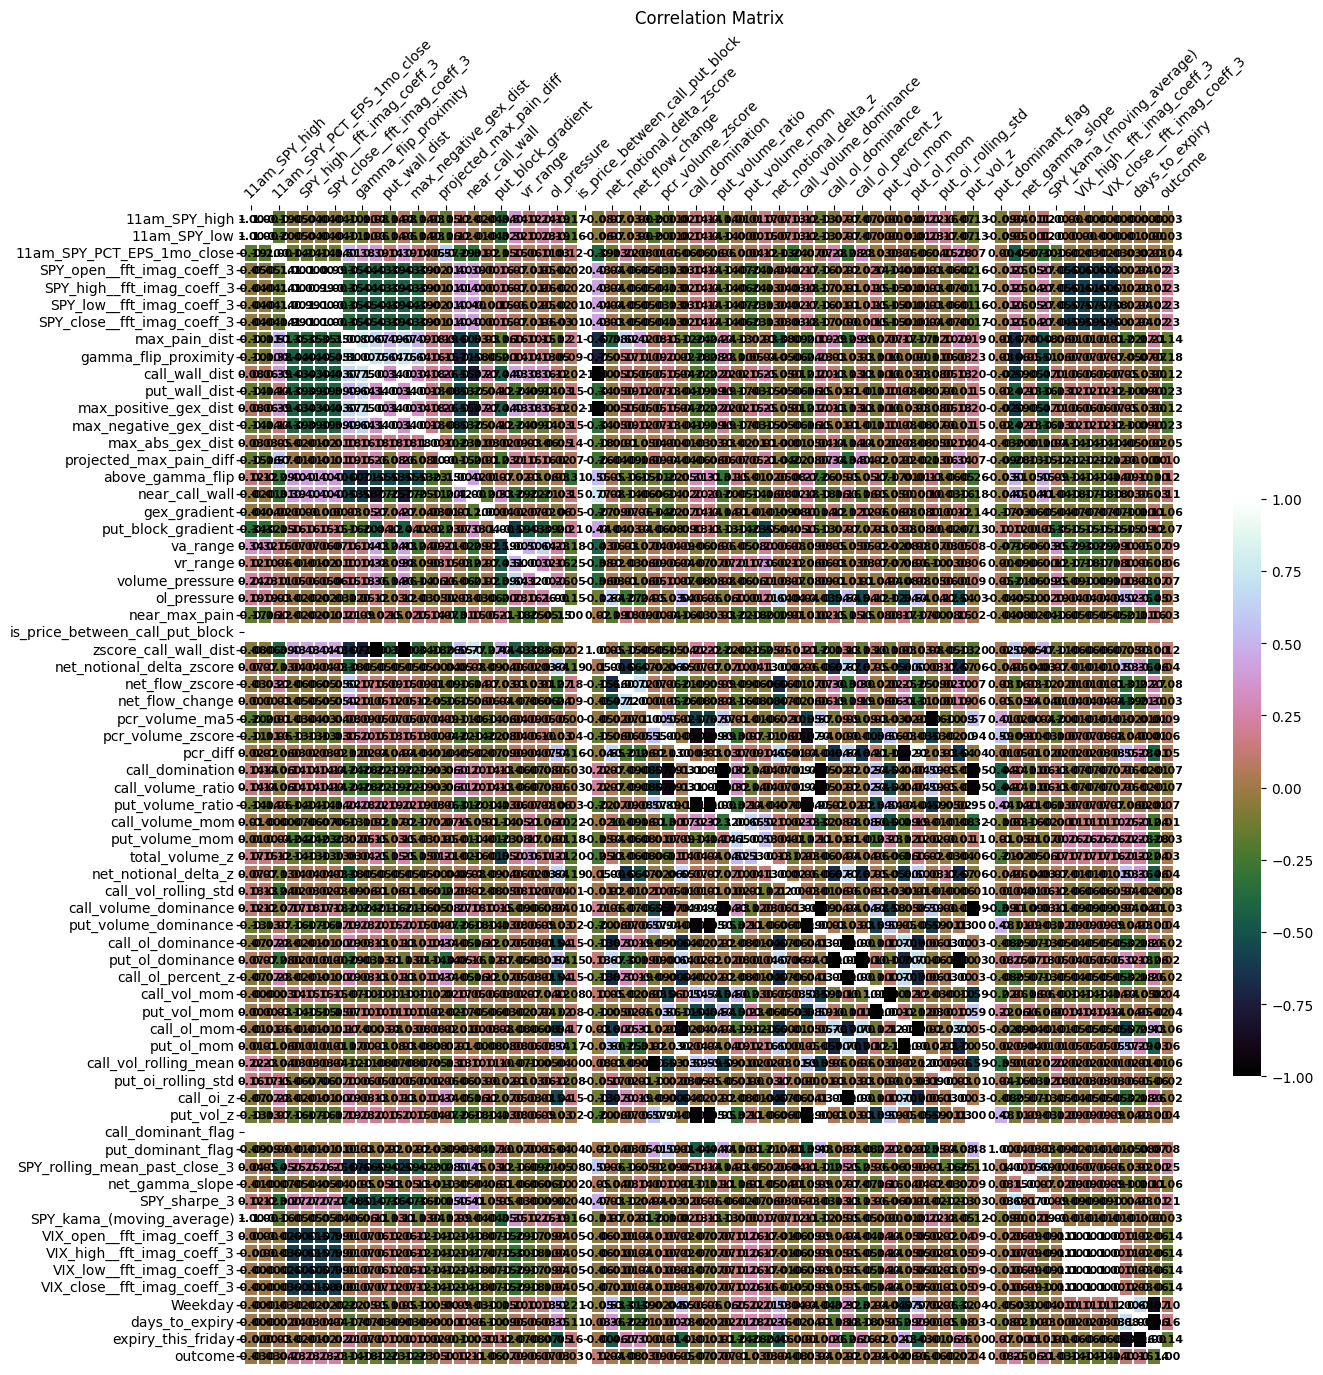

In [491]:
X = train_data.drop(columns=['outcome'])
y = train_data['outcome']

dfc = pd.concat((X,y), axis=1)

correlation = dfc.corr()

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
heatmap = sns.heatmap(correlation, vmax=1,annot=True,cmap='cubehelix',annot_kws={"size": 8,"color": "black","weight": "bold"},
fmt=".2f",  square=False, linewidths=0.1, cbar_kws={"shrink": 0.5},)
heatmap.xaxis.tick_top()
plt.xticks(rotation=45,ha='left',rotation_mode='anchor',fontsize=10)

The data exhibits very low multicollinearity among the predictors. linear models might suffice as there exist some levels of linear relationships between some of the variables with the outcome.

#### FEATURE SELECTION

##### REMOVE CONSTANT, QUASI-CONSTANT AND DUPLICATE COLUMNS

In [492]:
#Drop duplicate columns
drop_duplicates = DropDuplicateFeatures()
X_train_clean = drop_duplicates.fit_transform(train_data)
X_test_clean = drop_duplicates.transform(test_data)
print("Dropped duplicate columns:", drop_duplicates.features_to_drop_)

#Drop constant or quasi-constant columns
drop_constant = DropConstantFeatures(tol=0.98)
X_train_clean = drop_constant.fit_transform(X_train_clean)
X_test_clean = drop_constant.transform(X_test_clean)
print("Dropped constant/quasi-constant columns:", drop_constant.features_to_drop_)

# #Drop highly correlated columns
# drop_corr = DropCorrelatedFeatures(method='pearson', threshold=0.8)
# X_train_clean = drop_corr.fit_transform(X_train_clean)
# X_test_clean = drop_corr.transform(X_test_clean)
# print("Dropped correlated columns:", drop_corr.features_to_drop_)


Dropped duplicate columns: {'net_notional_delta_z', 'call_oi_z', 'max_positive_gex_dist', 'max_negative_gex_dist', 'call_dominant_flag'}
Dropped constant/quasi-constant columns: ['is_price_between_call_put_block']


##### PERFORM FEATURE SELECTION USING RECURSIVE FEATURE ELIMINATION METHOD

In [493]:
from sklearn.feature_selection import SequentialFeatureSelector

model = GaussianNB()

#defined the X and y components
X = X_train_clean.drop(columns=['outcome'])
y = X_train_clean['outcome']
tscv = TimeSeriesSplit(n_splits=5)
selector = SequentialFeatureSelector(GaussianNB(), n_features_to_select='auto', direction='forward', cv=tscv)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['SPY_open__fft_imag_coeff_3', 'SPY_low__fft_imag_coeff_3',
       'SPY_close__fft_imag_coeff_3', 'gamma_flip_proximity', 'call_wall_dist',
       'max_abs_gex_dist', 'projected_max_pain_diff', 'above_gamma_flip',
       'near_call_wall', 'gex_gradient', 'put_block_gradient', 'va_range',
       'volume_pressure', 'near_max_pain', 'zscore_call_wall_dist',
       'call_domination', 'call_volume_dominance', 'put_volume_dominance',
       'call_ol_dominance', 'put_ol_dominance', 'call_ol_percent_z',
       'call_vol_mom', 'put_vol_mom', 'put_oi_rolling_std', 'put_vol_z',
       'SPY_rolling_mean_past_close_3', 'SPY_sharpe_3', 'Weekday',
       'days_to_expiry', 'expiry_this_friday'],
      dtype='object')


#### MODEL BUILDING

In [494]:
# spot check the algorithms
base_estimator = DecisionTreeClassifier()
models = []
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('GBC', GradientBoostingClassifier(random_state=42)))
models.append(('XGB',XGBClassifier(eval_metric='logloss') ))
models.append(('ADB',AdaBoostClassifier(estimator=base_estimator)))


#scoring
precision = make_scorer(precision_score, average='macro')
recall = make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')

#### CROSS VALIDATION

In [495]:

df_copy = X_train_clean.copy()

# Drop rows with inf values (check only numeric columns)
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_copy = df_copy[~np.isinf(df_copy[numeric_cols]).any(axis=1)]

X = df_copy[selected_features].iloc[:]
y = df_copy['outcome'].iloc[:]

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    #kfold = KFold(n_splits=num_folds)
    tscv = TimeSeriesSplit(n_splits=5)
    #converted mean squared error to positive. Thelower the better
    cv_results = cross_val_score(model, X, y, cv=tscv, scoring=f1)
    kfold_results.append(cv_results)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.516138 (0.059072)
NB: 0.609192 (0.026412)
RF: 0.554517 (0.088393)
GBC: 0.517558 (0.085397)
XGB: 0.578591 (0.090358)
ADB: 0.508487 (0.058306)


#### EVALUATE CROSS VALIDATION RESULT

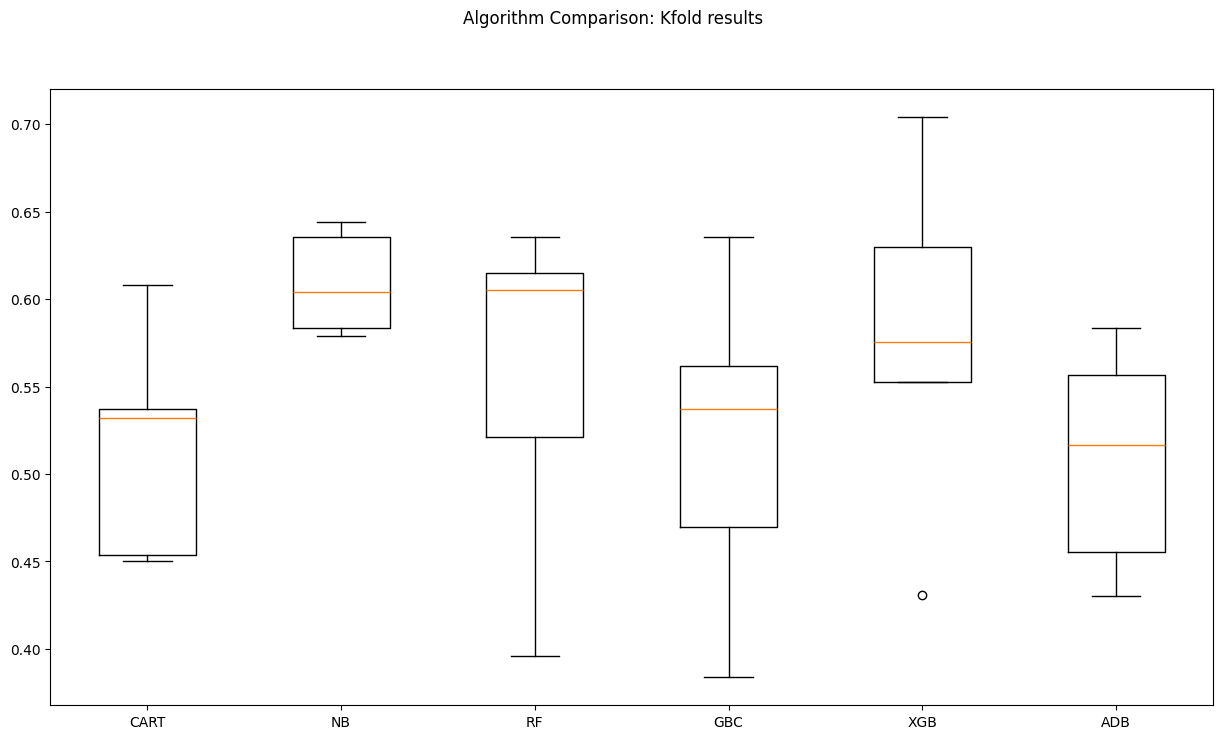

In [496]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

The best performing models are the linear discriminant(LDA) , linear regression and Naive bayes. While performance exhibits variability between 47% and 75%, average expected f1 score performs better than a random model 0f 50%

#### MODEL TUNING

The models are tuned to access the best model parameters

### NAIVE BAYES

#### MODEL TESTING WITH UNSEEN DATASET




#### NAIVE BAYES CLASSIFIER

#### RANDOM FOREST

In [497]:
rf = RandomForestClassifier(random_state=42)
params_dist={
   'n_estimators' : [20,30, 40, 50, 60, 80],
'max_depth' : [3, 5,7,8,10],
'criterion' : ["gini","entropy"]}

tvcs = TimeSeriesSplit(n_splits=10)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params_dist,
    n_iter=5,
    cv=tvcs,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X,y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=80; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_e

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=RandomForestClassifier(random_state=42), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 8, 10],
                                        'n_estimators': [20, 30, 40, 50, 60,
                                                         80]},
                   random_state=42, scoring='accuracy', verbose=2)

#### TRAIN AND TEST WITH ALL VARIABLES

In [498]:
#train set
df_copy = X_train_clean.copy()
X = df_copy.drop(columns=['outcome']).iloc[:]
y = df_copy['outcome'].iloc[:]

#unseen test set
df_test_final = X_test_clean.copy()
X_unseen_test = df_test_final.drop(columns=['outcome']).iloc[:]
y_unseen_test = df_test_final['outcome'].iloc[:]

#INSTANTIATE AND TRAIN MODEL
model = RandomForestClassifier(criterion= 'entropy', max_depth= 5, n_estimators=20,random_state=42)
model.fit(X, y)


##PREDICT TEST SET
y_pred = model.predict(X_unseen_test)


##CHECK RESULTS
# Classification report (includes precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_unseen_test, y_pred))

# If you want them separately:
precision_macro = precision_score(y_unseen_test, y_pred, average='macro')
recall_macro = recall_score(y_unseen_test, y_pred, average='macro')
f1_macro = f1_score(y_unseen_test, y_pred, average='macro')

print(f'Accuracy: {accuracy_score(y_unseen_test, y_pred)}')
print("\nConfusion Matrix:")
print(confusion_matrix(y_unseen_test, y_pred))
print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        76
           1       0.71      0.81      0.76        73

    accuracy                           0.74       149
   macro avg       0.75      0.75      0.74       149
weighted avg       0.75      0.74      0.74       149

Accuracy: 0.7449664429530202

Confusion Matrix:
[[52 24]
 [14 59]]

Macro Precision: 0.7494
Macro Recall: 0.7462
Macro F1 Score: 0.7444


#### DETERMINE BEST FEATURES FROM THE MODEL ABOVE

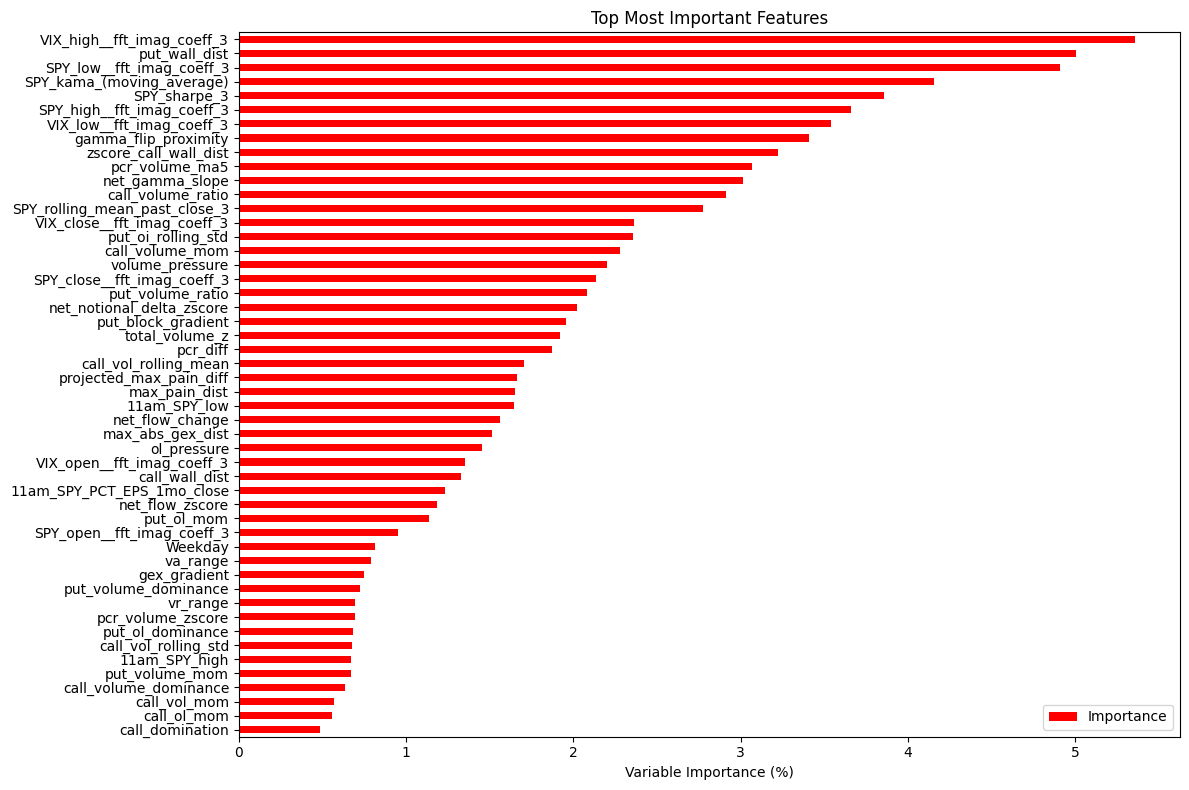

In [499]:
Importance = pd.DataFrame({'Importance': model.feature_importances_ * 100}, index=X.columns)
# Select top features
top_features = Importance.sort_values('Importance', ascending=False).head(50)
top_features.sort_values('Importance').plot(kind='barh', color='r', figsize=(12, 8))
plt.xlabel('Variable Importance (%)')
plt.title('Top Most Important Features')
plt.tight_layout()
plt.show()

#### USE TOP FEATURES TO TRAIN THE MODEL

In [500]:
#train set
df_copy = X_train_clean.copy()
X = df_copy[top_features.index[:50]].iloc[:]
y = df_copy['outcome'].iloc[:]

#unseen test set
df_test_final = X_test_clean.copy()
X_unseen_test = df_test_final[top_features.index[:50]].iloc[:]
y_unseen_test = df_test_final['outcome'].iloc[:]

#INSTANTIATE AND TRAIN MODEL
model = RandomForestClassifier(criterion= 'entropy', max_depth= 2, n_estimators= 20,random_state=42)
model.fit(X, y)


##PREDICT TEST SET
y_pred = model.predict(X_unseen_test)


##CHECK RESULTS
# Classification report (includes precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_unseen_test, y_pred))

# If you want them separately:
precision_macro = precision_score(y_unseen_test, y_pred, average='macro')
recall_macro = recall_score(y_unseen_test, y_pred, average='macro')
f1_macro = f1_score(y_unseen_test, y_pred, average='macro')

print(f'Accuracy: {accuracy_score(y_unseen_test, y_pred)}')
print("\nConfusion Matrix:")
print(confusion_matrix(y_unseen_test, y_pred))
print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        76
           1       0.75      0.73      0.74        73

    accuracy                           0.74       149
   macro avg       0.75      0.74      0.74       149
weighted avg       0.75      0.74      0.74       149

Accuracy: 0.7449664429530202

Confusion Matrix:
[[58 18]
 [20 53]]

Macro Precision: 0.7450
Macro Recall: 0.7446
Macro F1 Score: 0.7447
